# Unsupervised Learning for Predicting Text Difficulty

Author: Yanying Jiang

Since we don’t have a target variable, the goal of our unsupervised learning approach is not to make predictions on the text difficulty. We will instead use unsupervised learning algorithms to discover the patterns in the dataset, for instance, how many clusters are there? What are the most popular topics? Then we will incorporate these findings as a way of feature representation and enhance our supervised learning models accordingly. The two models used in this section are K-Means and Topic Modeling, which will be illustrated in details below. 

## Import Packages

In [44]:
import numpy as np
import pandas as pd
import nltk

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc,silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [100]:
#!pip install fasttext
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D
import fasttext 

## Load the Data 
The feature representation used is the vectorized data output from the word2vec algorithm discussed in the feature engineering section above. It’s based on a bag of words and has 300 columns. 

The input data has 301 Features in total: 300 columns from Word2Vec and one column for sentence length. 

In [89]:
X_train_301 = np.load('work/X_train.npy', allow_pickle=True)
y_train_301 = np.load('work/y_train.npy', allow_pickle=True)
X_test_301 = np.load('work/X_test.npy', allow_pickle=True)
y_test_301 = np.load('work/y_test.npy', allow_pickle=True)

Removing the sentence length feature as it added too much noise for K-Means 

In [63]:
X_train = X_train_301[:,:300]
print(X_train.shape)
X_test = X_test_301[:,:300]
print(X_test.shape)


(333414, 300)
(83354, 300)


## Find the Optimal Number of Clusters (k) for K Means 

K-Means is commonly used as a clustering algorithm. It’s pretty easy to interpret and visualize. The distance calculation metrics we used is the sum of square distance within clusters, and our goal is to minimize this distance, i.e. the distance between the centroid of the cluster and all of the data points within the cluster. 

We will apply 'elbow' method to figure out what is the best number of clusters by minimizing the sum of square distance within clusters i.e. the distance between data points in a cluster and the centroid of the cluster.  

The elbow plot shows the sum of squared distance on the y-axis and we decide the k as the optimal at the point where the elbow point is at.  In the below elbow plot, we should select k = 2 for our K-means clustering. 

In [7]:
inertia = []
K = range(1,10)
  
for k in K:
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(X_train)
    inertia.append(model.inertia_)

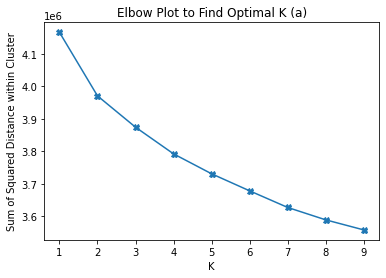

In [8]:
# Visualize using Elbow Plot
plt.plot(K, inertia, 'X-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance within Cluster')
plt.title('Elbow Plot to Find Optimal K (a)')
plt.show()

In [9]:
# Build the K-means model
km = KMeans(n_clusters=5,random_state = 42)
y_kmeans = km.fit_predict(X_train)

In [10]:
km.labels_

array([1, 2, 0, ..., 4, 2, 1], dtype=int32)

In [11]:
silh_score = silhouette_score(X_train, km.labels_,sample_size = 50000)
print("silhouette_score:",silh_score)

silhouette_score: 0.03420135064756621


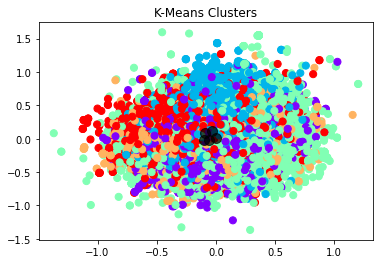

In [12]:
# Visualize clusters 

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.7)
plt.title('K-Means Clusters')
plt.show()
plt.show()

The scatter plot cannot present the clusters of a high-dimentional dataset, we will apply PCA for visualizing the clusters. 

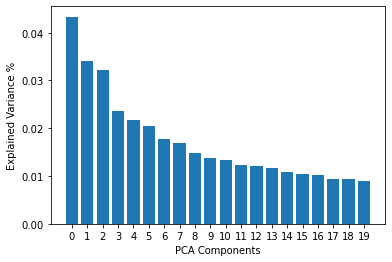

In [91]:
# Code in this cell is inspired by https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X_train)
# create pca 
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

From the above chart we can see that the first 3 principal components explains most of the variances. So we train the K-Means model with the first 3 PCs.

In [94]:
km_PCA = KMeans(n_clusters=2,random_state=42)
y_km_PCA = km_PCA.fit_predict(PCA_components.iloc[:,:3])


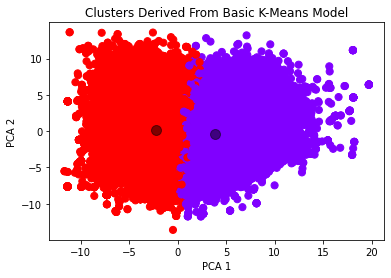

In [95]:
# Visualize clusters 
plt.scatter(PCA_components.iloc[:,0], PCA_components.iloc[:,1], c=y_km_PCA, s=50, cmap='rainbow')
centers = km_PCA.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Derived From Basic K-Means Model')
plt.show()



Text(0.5, 0.92, '3D Clustering using Basic K-Means')

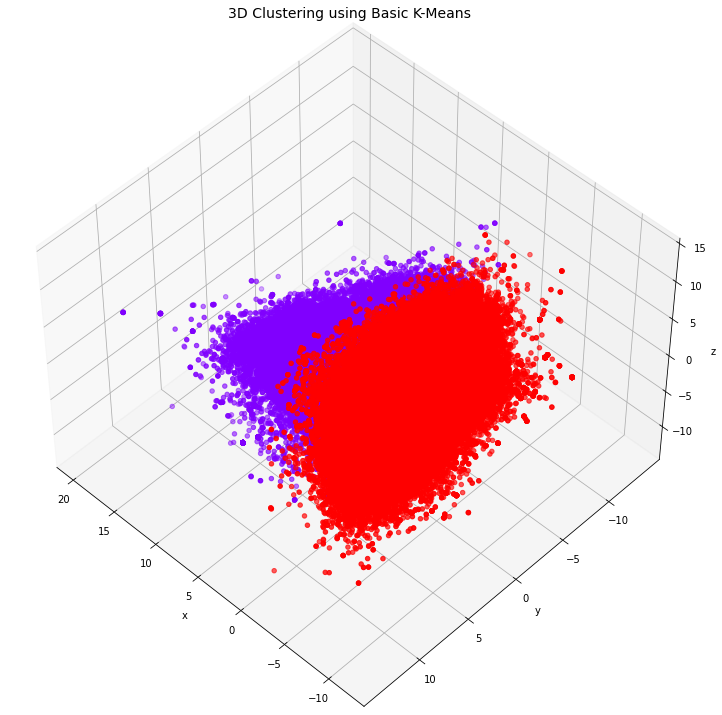

In [96]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(PCA_components.iloc[:,0], PCA_components.iloc[:,1],PCA_components.iloc[:,2],c=y_km_PCA, cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.set_facecolor('white')
plt.title("3D Clustering using Basic K-Means", fontsize=14)

## Latent Semantic Indexing: K-Means using Truncated SVD

To further improve the model, we wanted to see if Latent Semantic Indexing will make a difference on the result. The method used is Truncated SVD, which is also a dimension reduction technique. According to the Hughes phenomenon, the performance of a classifier will increase along with the increase in the number of features, but when reaching a certain point, the trend will be reversed and it will start to decrease. Thus dimension reduction techniques not only can help us visualize the data, like how we did using PCA above, but also can increase the model performance. 

#### Parameter Tuning
Parameter tuning is conducted to find the optimal number of components for Truncated SVD. We set the list of components from 10 to 250, because the number of features in the input data is 300 and the number of components can not exceed that. We were able to export the following list of cumulative explained variance and the corresponding number of components: 

In [19]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [10,50,100,150,200,250] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and cumulative explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

Number of components = 10 and cumulative explained variance = 0.29339058546180735
Number of components = 50 and cumulative explained variance = 0.574022829650412
Number of components = 100 and cumulative explained variance = 0.7463896365422791
Number of components = 150 and cumulative explained variance = 0.8688883195680406
Number of components = 200 and cumulative explained variance = 0.9596731109707911
Number of components = 250 and cumulative explained variance = 0.9974035017929069


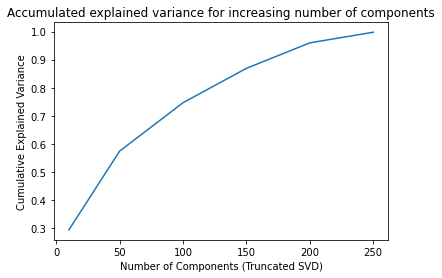

In [20]:
plt.plot(n_comp, explained)
plt.xlabel('Number of Components (Truncated SVD)')
plt.ylabel("Cumulative Explained Variance")
plt.title("Accumulated explained variance for increasing number of components")
plt.show()

#### Create K-Means with Optimal Number of Components
Since 150 components can explain more than 85% of the variances, we decided to try the model with n_components = 150. 

In [21]:
svd = TruncatedSVD(n_components= 150)
SVD_X_train = svd.fit_transform(X_train)

In [22]:
# cumulated explained_variance
svd.explained_variance_ratio_.sum()

0.8688310254858982

We again use the elbow method to find the optimal k, the plot below shows that k=2 is still the optimal elbow point.

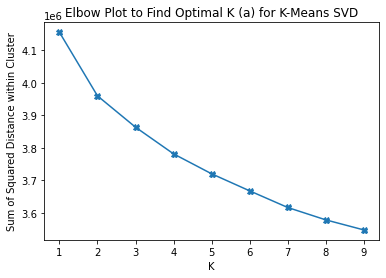

In [83]:
inertia = []
K = range(1,10)
  
for k in K:
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(SVD_X_train)
    inertia.append(model.inertia_)
    
plt.plot(K, inertia, 'X-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance within Cluster')
plt.title('Elbow Plot to Find Optimal K (a) for K-Means SVD' )
plt.show()

In [24]:
optimal_k = 2

In [25]:
kmeans_SVD = KMeans(n_clusters=optimal_k,random_state = 42)
y_kmeans_SVD = kmeans_SVD.fit_predict(SVD_X_train)


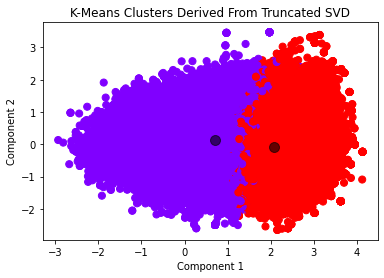

In [26]:
plt.scatter(SVD_X_train[:, 0], SVD_X_train[:, 1], c=y_kmeans_SVD, s=50, cmap='rainbow')
centers = kmeans_SVD.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-Means Clusters Derived From Truncated SVD')
plt.show()

Text(0.5, 0.92, '3D Clustering using K-Means with truncated SVD')

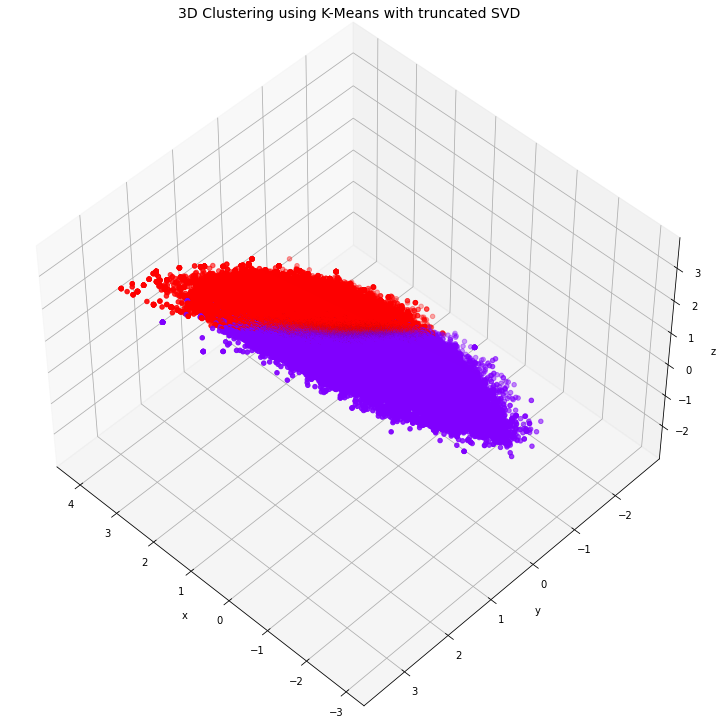

In [87]:
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(SVD_X_train[:, 0], SVD_X_train[:, 1],SVD_X_train[:, 1],c=y_kmeans_SVD, cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.set_facecolor('white')
plt.title("3D Clustering using K-Means with truncated SVD", fontsize=14)

#### Evaluate the Model Using Silhouette Score

In [27]:
silh_score_SVD = silhouette_score(SVD_X_train, kmeans_SVD.labels_,sample_size = 50000)
print("silhouette_score:",silh_score_SVD)

silhouette_score: 0.05715532529009496


#### Sensitivity Analysis Conducted for Number of Components and Silhouette Score

In [28]:
n_comp = [10,50,100,150,200,250] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    SVD_X_train = svd.fit_transform(X_train)
    kmeans_SVD = KMeans(n_clusters=4,random_state = 42)
    kmeans_SVD.fit_predict(SVD_X_train)
    silh_score_SVD = silhouette_score(SVD_X_train, kmeans_SVD.labels_,sample_size = 50000)
    print("Number of Components:",x," silhouette_score:",silh_score_SVD)

Number of Components: 10  silhouette_score: 0.13542707504346901
Number of Components: 50  silhouette_score: 0.06668190949359891
Number of Components: 100  silhouette_score: 0.05096968225150129
Number of Components: 150  silhouette_score: 0.04541470863748594
Number of Components: 200  silhouette_score: 0.04200573480564999
Number of Components: 250  silhouette_score: 0.040128252998113165


#### Create the Best K-Means Model with SVD in Terms of Silhouette Score 

In [45]:
svd_best = TruncatedSVD(n_components=10)
SVD_best_X_train = svd_best.fit_transform(X_train)
kmeans_SVD_best = KMeans(n_clusters=2,random_state = 42)
kmeans_SVD_best.fit_predict(SVD_best_X_train)
silh_score_SVD_best = silhouette_score(SVD_best_X_train, kmeans_SVD_best.labels_,sample_size = 50000)
print("Number of Components:",10," silhouette_score:",silh_score_SVD_best)

Number of Components: 250  silhouette_score: 0.1502102535461362


#### Add Predicted Cluster as a Feature and Save  

In [79]:
SVD_Pred_train = kmeans_SVD_best.predict(SVD_best_X_train)
print(len(SVD_Pred_train))
print(SVD_Pred_train.reshape(-1,1))
X_train_plus = np.append(X_train_301,SVD_Pred_train.reshape(-1,1),axis=1)
# X_train_plus.to_csv('X_train_plus.csv', index = False)
np.save('X_train_plus.npy', X_train_plus)

333414
[[0]
 [1]
 [0]
 ...
 [1]
 [1]
 [0]]


In [82]:
SVD_best_X_test = svd_best.transform(X_test)
SVD_Pred_test = kmeans_SVD_best.predict(SVD_best_X_test)
print(len(SVD_Pred_test))
X_test_plus = np.append(X_test_301,SVD_Pred_test.reshape(-1,1),axis=1)
np.save('X_test_plus.npy',X_test_plus)

83354


### Word Embedding with fasttext 

Let's try word embedding on pre-trained models.

What word embedding do is representing words as vectors in a space where similar words are mapped near each other.

Due to the nature of the task, that we are classifying the text data by its readability, the sequential relationship between words can play an important role. People sometimes rely on the context to understand an article or a sentence. So for clustering purposes, word embedding could be a useful method. There are a bunch of pre-trained models out there based on word embedding. fastText is the one we would like to explore, as it incorporates n-gram bag of words represented using word vectors, and enhances it by preserving some of the sequential information that can factor in the order of words in a sentence. As text difficulty can be impacted by the surrounding words of each word, fastText may be a good choice for our clustering task. 

In terms of feature representation, we used the original training dataset downloaded from Kaggle to train the fastText model. And then we use the output word vectors as the input data for K-Means. 


In [29]:
data = pd.read_csv('WikiLarge_Train.csv')
data.head()
data['original_text'].to_csv('train.txt', index = False)

In [30]:
# !pip install fasttext==0.9.2

In [31]:
# import fasttext # 
model = fasttext.train_unsupervised('train.txt',model='skipgram',dim=100)  #default to skipgram model and output 100-dimensional vectors

Read 9M words
Number of words:  67434
Number of labels: 0
Progress: 100.0% words/sec/thread:   85232 lr:  0.000000 avg.loss:  1.729857 ETA:   0h 0m 0s 75.8% words/sec/thread:   85182 lr:  0.012104 avg.loss:  1.773862 ETA:   0h 0m19s 99.4% words/sec/thread:   85337 lr:  0.000276 avg.loss:  1.730613 ETA:   0h 0m 0s


In [40]:
data['vec'] = data['original_text'].apply(lambda x: model.get_sentence_vector(x))   #get_sentence_vector automatically tokenize the sentences

In [41]:
kmeans = KMeans(n_clusters=2,random_state = 42)
data['cluster'] = kmeans.fit_predict(data['vec'].values.tolist())

In [34]:
silh_score_fasttext = silhouette_score(data['vec'].values.tolist(), kmeans.labels_,sample_size = 50000)
print("silhouette_score:",silh_score_fasttext)

silhouette_score: 0.12171599


The main parameters we tuned is k of K-Means. Since the feature representation is different from the basic K-means model, the optimal k can be different as well. We calculated silhouette score for k in range(2, 10), the result shows that k = 2 has the best performance. 

In [84]:
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state = 42)
    data['cluster_test'] = kmeans.fit_predict(data['vec'].values.tolist())
    silh_score_fasttext = silhouette_score(data['vec'].values.tolist(), kmeans.labels_,sample_size = 50000)
    print("k:",k," silhouette_score:",silh_score_fasttext)

k: 2  silhouette_score: 0.122551434
k: 3  silhouette_score: 0.09756829
k: 4  silhouette_score: 0.082048975
k: 5  silhouette_score: 0.06895258
k: 6  silhouette_score: 0.06852683
k: 7  silhouette_score: 0.07046127
k: 8  silhouette_score: 0.05481826
k: 9  silhouette_score: 0.046708707


In [36]:
data.cluster.value_counts()

2    82735
0    77914
4    73838
5    59195
1    48034
7    36849
6    18345
3    17025
8     2833
Name: cluster, dtype: int64

In [37]:
data['vec']

0         [0.020066494, 0.050777245, 0.07022943, -0.0700...
1         [-0.007288944, 0.036965225, 0.08808462, -0.049...
2         [0.048902757, 0.089540854, 0.08452788, -0.1066...
3         [0.048531543, 0.039478768, 0.13411261, -0.1344...
4         [0.05387028, 0.048356317, 0.0330545, -0.067567...
                                ...                        
416763    [0.07987461, 0.051120374, 0.08068772, -0.09679...
416764    [0.07081561, 0.039237317, 0.09718794, -0.08311...
416765    [0.03191029, 0.017200796, 0.1339912, -0.042093...
416766    [0.051717605, 0.021420615, 0.09858723, -0.0859...
416767    [-0.0034674506, 0.097293586, 0.12598768, -0.14...
Name: vec, Length: 416768, dtype: object

### Visualize clustering results using PCA

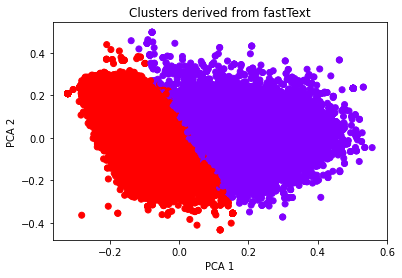

In [98]:
#The code in this cell is inspired by Ignasius Harvey Jul 1, 2020 https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20
pca = PCA(n_components=3)
data['x'] = pca.fit_transform(data['vec'].values.tolist())[:,0] #first dimension
data['y'] = pca.fit_transform(data['vec'].values.tolist())[:,1] #second dimension
data['z'] = pca.fit_transform(data['vec'].values.tolist())[:,2] #third dimension 
plt.scatter(data['x'], data['y'], c=data['cluster'], cmap='rainbow')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("Clusters derived from fastText")
plt.show()

Text(0.5, 0.92, '3D Plot of Clusters derived from fastText')

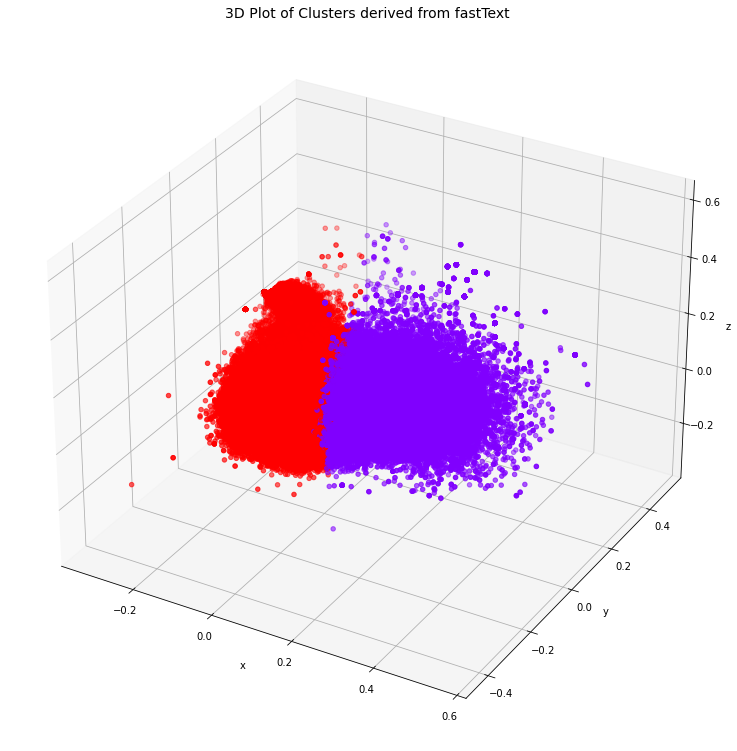

In [99]:
#The code in this cell is inspired by Ignasius Harvey Jul 1, 2020 https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20

# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(data['x'], data['y'], data['z'],c=data['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.set_facecolor('white')
plt.title("3D Plot of Clusters derived from fastText", fontsize=14)


## Reference

Kamil Mysiak Jul 13, 2020 https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

Rukshan Pramoditha Apr 24, 2022 https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d

Mrunal Sawant Jul 9, 2019 https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d


Ignasius Harvey Jul 1, 2020 https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20


Dmitriy Feb 20, 2019 https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2 



